In [1]:
'''
Based on correlation analysis find the best number of clusters and perform a GO enrichment analysis

1) Select a number of clusters with most uniformly distributed number of genes for:
1-1) all significant genes
1-2) subset of genes (DNA metabolic etc)
2) Find GO enrichment terms for each cluster

input: (output files from corr_analysis.ipynb)
all_cluster_file 'results/all_cluster_id.tsv'
meta_cluster_file 'results/meta_cluster_id.tsv'

output:
go_enrichment_file 'results/cluster_go_enrichment.xlsx'
'''

"\nBased on correlation analysis find the best number of clusters and perform a GO enrichment analysis\n\n1) Select a number of clusters with most uniformly distributed number of genes for:\n1-1) all significant genes\n1-2) subset of genes (DNA metabolic etc)\n2) Find GO enrichment terms for each cluster\n\ninput: (output files from corr_analysis.ipynb)\nall_cluster_file 'results/all_cluster_id.tsv'\nmeta_cluster_file 'results/meta_cluster_id.tsv'\n\noutput:\ngo_enrichment_file 'results/cluster_go_enrichment.xlsx'\n"

In [39]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [4]:
# Input files
all_cluster_file = 'results/all_cluster_id.tsv'
meta_cluster_file = 'results/meta_cluster_id.tsv'
go_file = 'data/c5.bp.v6.1.symbols.gmt'
corr_count_file = "results/corr_expr_sigma_count.tsv"
gene_name_file = 'data/ensembl_to_name.txt'

In [10]:
# Read cluster files
all_cluster_df = pd.read_csv(all_cluster_file, sep='\t', index_col=0)
meta_cluster_df = pd.read_csv(meta_cluster_file, sep='\t', index_col=0)

In [16]:
# read correlation file
corr_count = pd.read_csv(corr_count_file, sep="\t", index_col=0)

# Translate ENSEMBL gene IDs to gene names
gene_names_df = pd.read_csv(gene_name_file, sep='\t', index_col=0)
gene_names_dic = gene_names_df.to_dict()['Gene name']

def rename_ensembl(df, gene_names_dic):
    ensembl_ids = pd.Series([ensembl_id.split('.')[0] for ensembl_id in list(df.index)])
    df.index = ensembl_ids.map(gene_names_dic)

rename_ensembl(corr_count, gene_names_dic)

# Drop null indecies
corr_count = corr_count[corr_count.index.notnull()]

sigs = ['SBS1','SBS2','SBS3','SBS5','SBS8','SBS9','SBS13','SBS15','SBS18','SBS20',
        'SBS26','SBS36','SBS39','SBS40a','SBS40b','SBS40c','SBS44','SBS98']

corr_count = corr_count[sigs]

# Find the best clustering

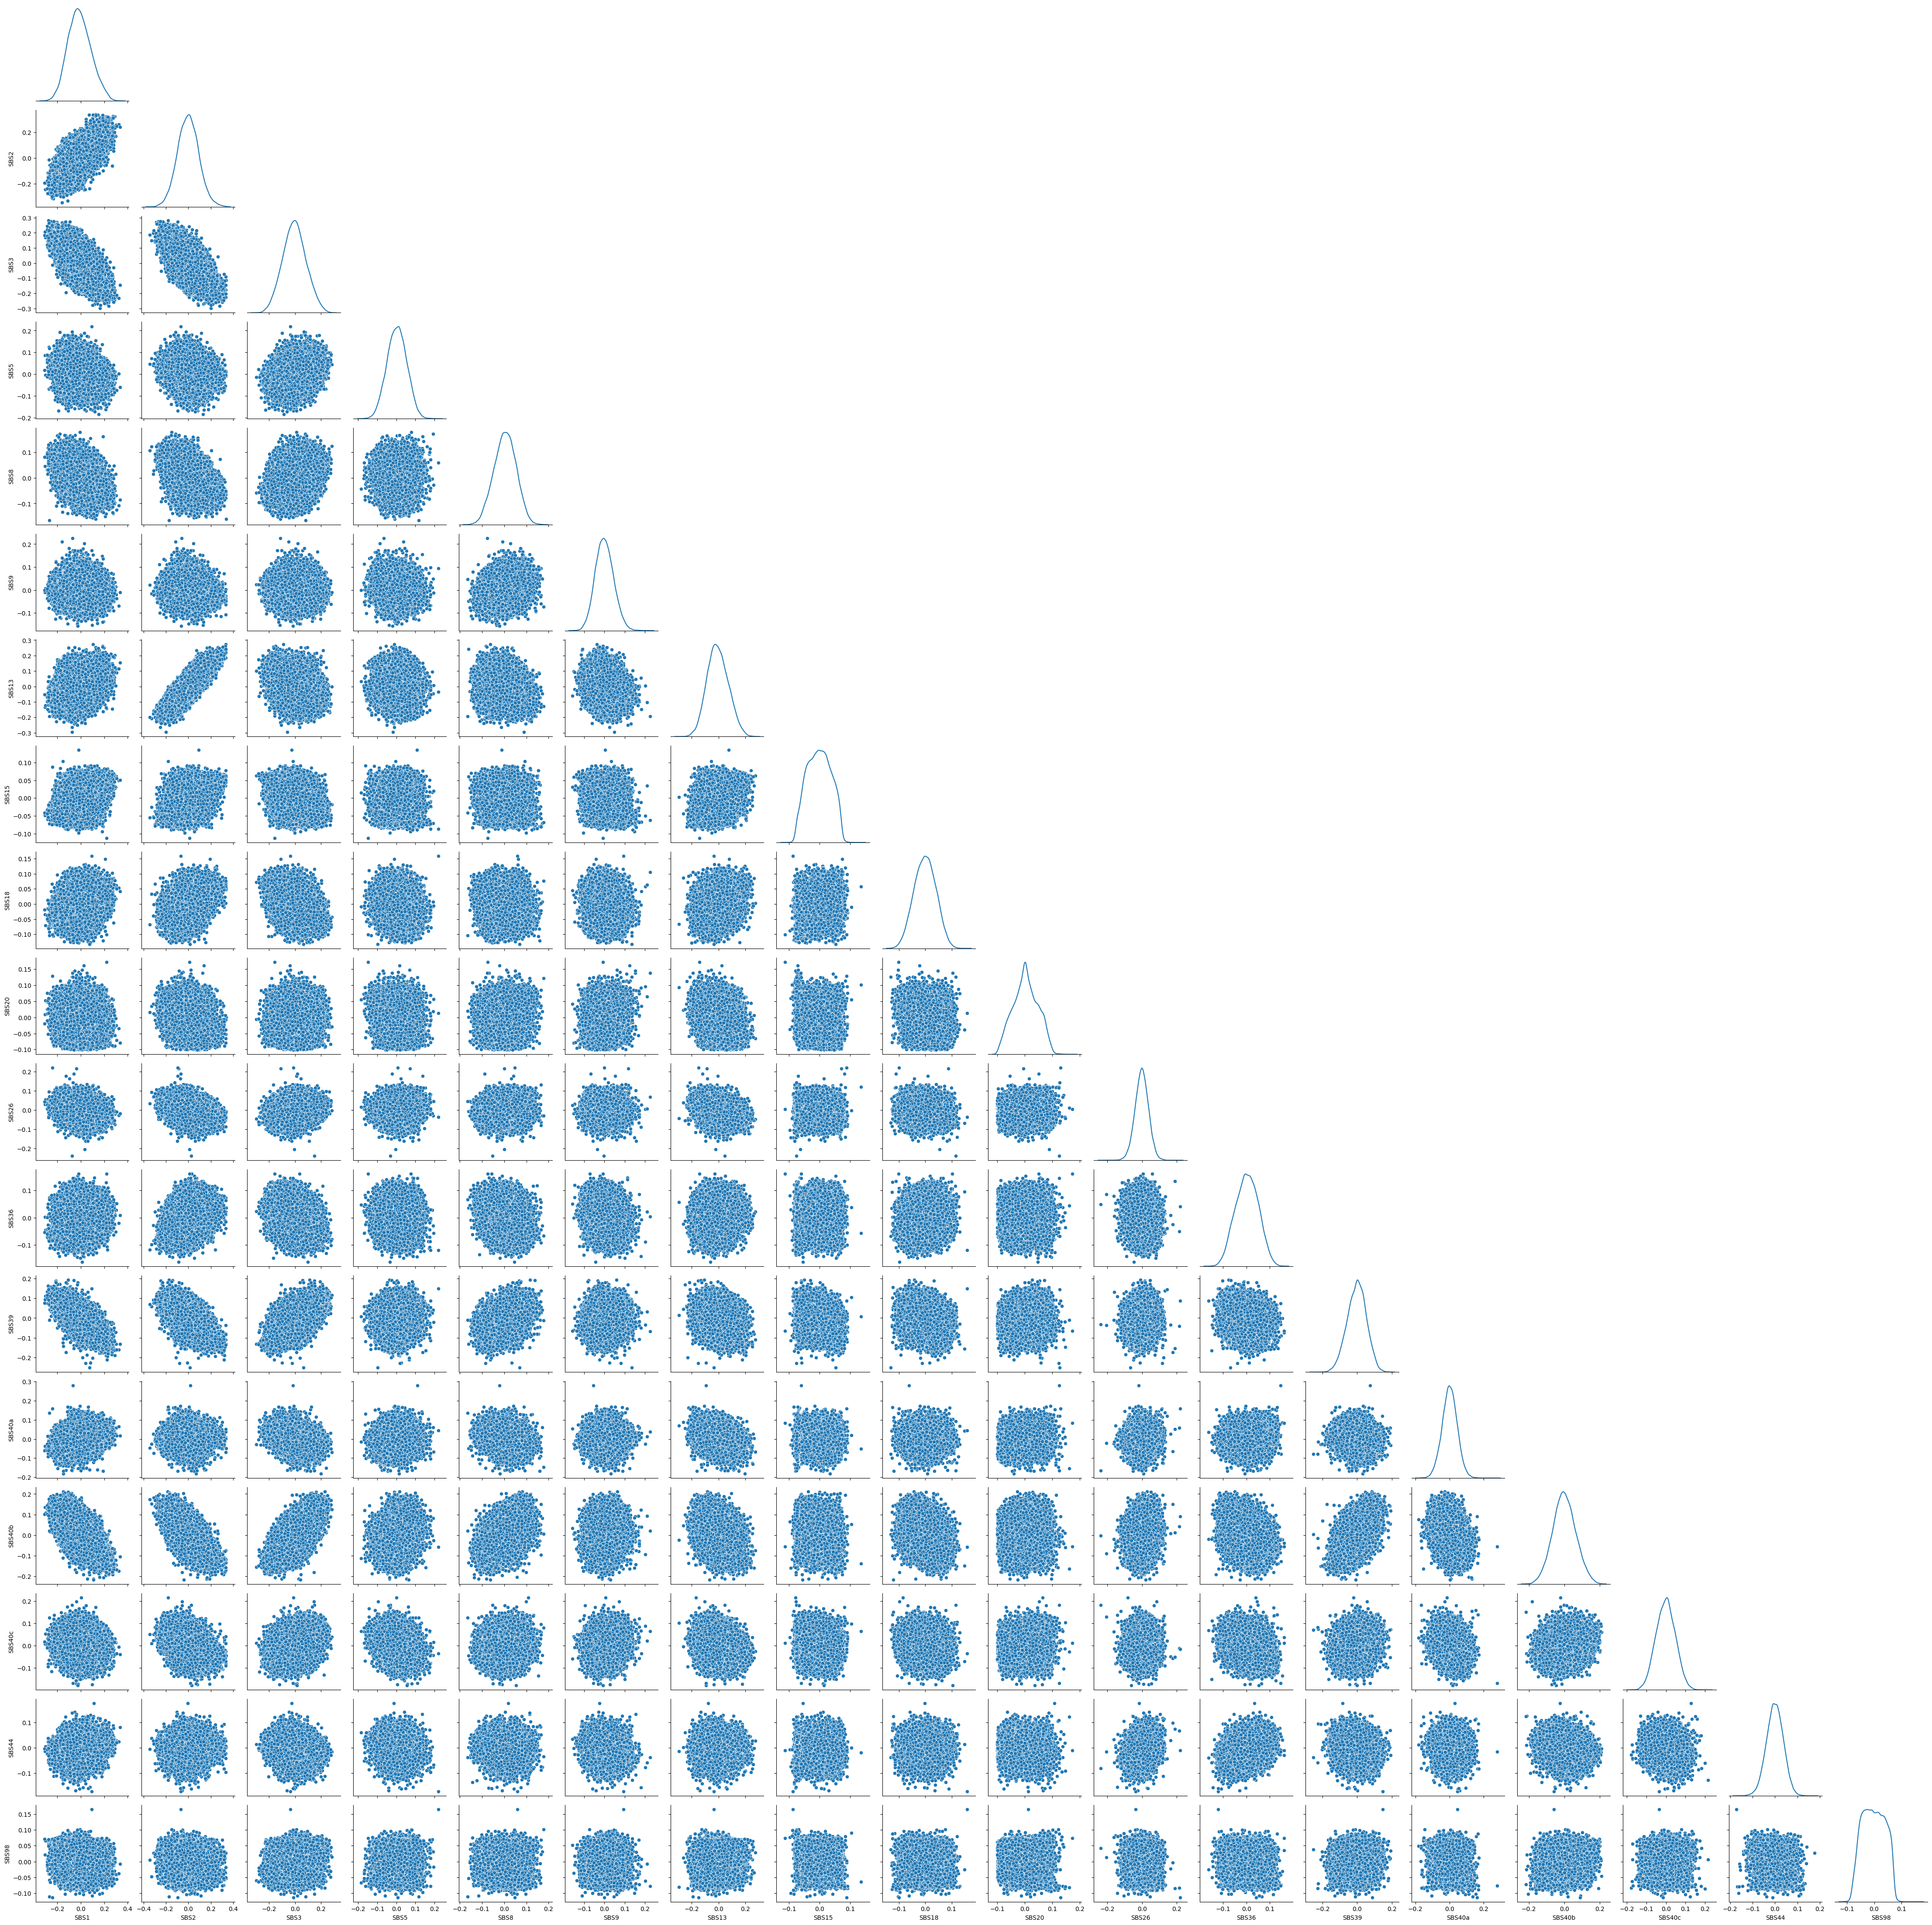

In [34]:
# TODO Choose the best clustering
# Plot correlation between signatures
g = sns.PairGrid(corr_count[corr_count != 0].dropna(), diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

# GO enrichment in clusters (for each k-clustering)

In [13]:
# GO genes
lines = [l.split() for l in open(go_file).readlines()]
go_dic = {}
for l in lines:
    go_dic[l[0]] = l[2:]
    
# GO_meta_genes
dna_meta_genes = list(filter(lambda l: l[0] == "GO_DNA_METABOLIC_PROCESS", lines))[0][2:]

In [17]:
# Calculate GO enrichment for each cluster (for each number of clusters)
N = 42130  # All examined genes
genes_of_interest = set([])

for n_clusters in all_cluster_df.columns:
    print(f'\nNumber of clusters: {n_clusters}')
    with pd.ExcelWriter(f'results/cluster_go_enrichment/cluster_go_enrichment_{n_clusters}.xlsx', engine='xlsxwriter') as writer:
        for cluster in sorted(all_cluster_df[n_clusters].unique()):
            # Define genes belonging to the cluster
            cluster_genes = list(all_cluster_df[n_clusters].loc[all_cluster_df[n_clusters] == cluster].index)
            K = len(cluster_genes)
            print(f'Cluster {cluster}: {K} genes')

            # Dataframe for cluster GO enrichment
            cluster_go_df = pd.DataFrame(list(go_dic.keys()), columns=['GO term'])

            go_genes_col = []
            k_col = []
            n_col = []
            pv_col = []
            
            # Perform hypergeometric test
            for go_term in cluster_go_df['GO term']:
                go_genes = [gene for gene in cluster_genes if gene in go_dic[go_term]]
                genes_of_interest = genes_of_interest.union(go_genes)  # Collect only gene names associated with GO terms
                k = len(go_genes)
                n = len(go_dic[go_term])
                pv = ss.hypergeom.sf(k-1, N, K, n)

                go_genes_col.append(go_genes)
                k_col.append(k)
                n_col.append(n)
                pv_col.append(pv)

            cluster_go_df['genes'] = go_genes_col
            cluster_go_df['k: number of selected genes in GO term'] = k_col
            cluster_go_df['n: number of genes in GO term'] = n_col
            cluster_go_df['p value'] = pv_col

            # Remove terms with p value >= 0.05
            cluster_go_df = cluster_go_df[cluster_go_df['p value'] < 0.05]
            cluster_go_df.sort_values(by=['p value'], ascending=True, inplace=True)

            # Save cluster GO enrichment data to a separate excel sheet
            cluster_go_df.to_excel(writer, sheet_name=f'aC{cluster}')

Clustering: k=4
Cluster 1: 1186 genes
Cluster 2: 1026 genes
Cluster 3: 517 genes
Cluster 4: 880 genes
Clustering: k=5
Cluster 1: 1186 genes
Cluster 2: 362 genes
Cluster 3: 664 genes
Cluster 4: 517 genes
Cluster 5: 880 genes
Clustering: k=6
Cluster 1: 1186 genes
Cluster 2: 362 genes
Cluster 3: 664 genes
Cluster 4: 517 genes
Cluster 5: 752 genes
Cluster 6: 128 genes
Clustering: k=7
Cluster 1: 1186 genes
Cluster 2: 362 genes
Cluster 3: 168 genes
Cluster 4: 496 genes
Cluster 5: 517 genes
Cluster 6: 752 genes
Cluster 7: 128 genes
Clustering: k=8
Cluster 1: 1186 genes
Cluster 2: 362 genes
Cluster 3: 168 genes
Cluster 4: 496 genes
Cluster 5: 517 genes
Cluster 6: 752 genes
Cluster 7: 27 genes
Cluster 8: 101 genes
Clustering: k=9
Cluster 1: 340 genes
Cluster 2: 846 genes
Cluster 3: 362 genes
Cluster 4: 168 genes
Cluster 5: 496 genes
Cluster 6: 517 genes
Cluster 7: 752 genes
Cluster 8: 27 genes
Cluster 9: 101 genes
Clustering: k=10
Cluster 1: 340 genes
Cluster 2: 846 genes
Cluster 3: 362 genes
C

# Average cluster expression-signature correlation

In [104]:
def avg_cluster_corr(corr_df, n_clusters):
    '''
    Return a dataframe of average correlation between gene expression and signature occurence for each cluster
    '''
    # Assign genes to clusters
    corr_df_kn = corr_df.copy()
    corr_df_kn['cluster'] = corr_df_kn.index.map(all_cluster_df[n_clusters].to_dict())

    # Calculate average correlation for each cluster
    avg_corr_df = corr_df_kn.groupby('cluster').mean()

    return avg_corr_df
    

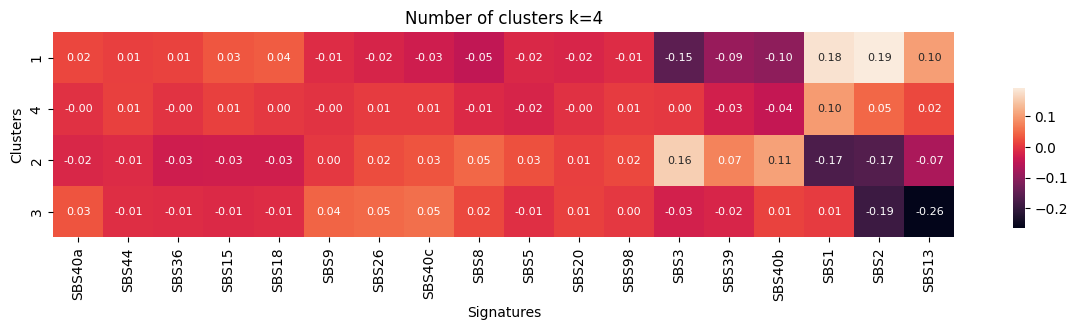

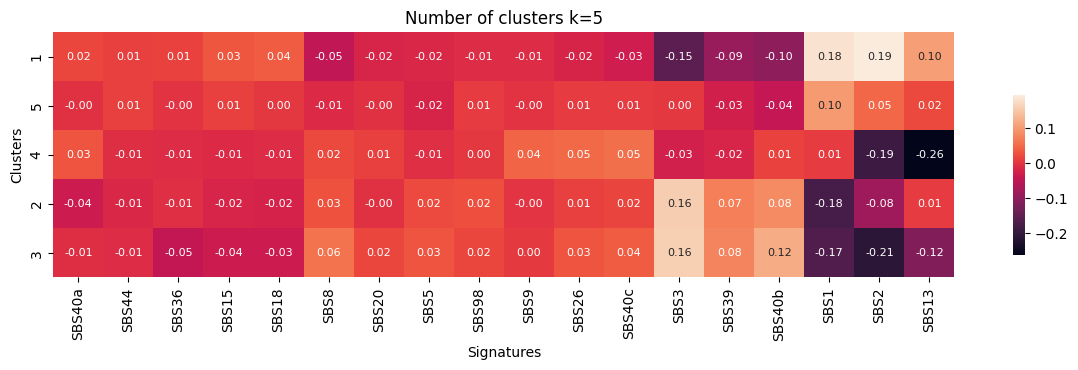

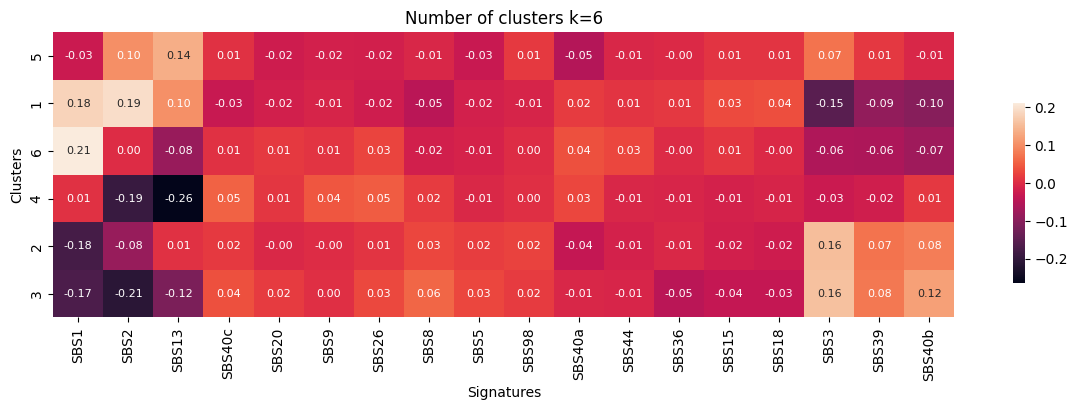

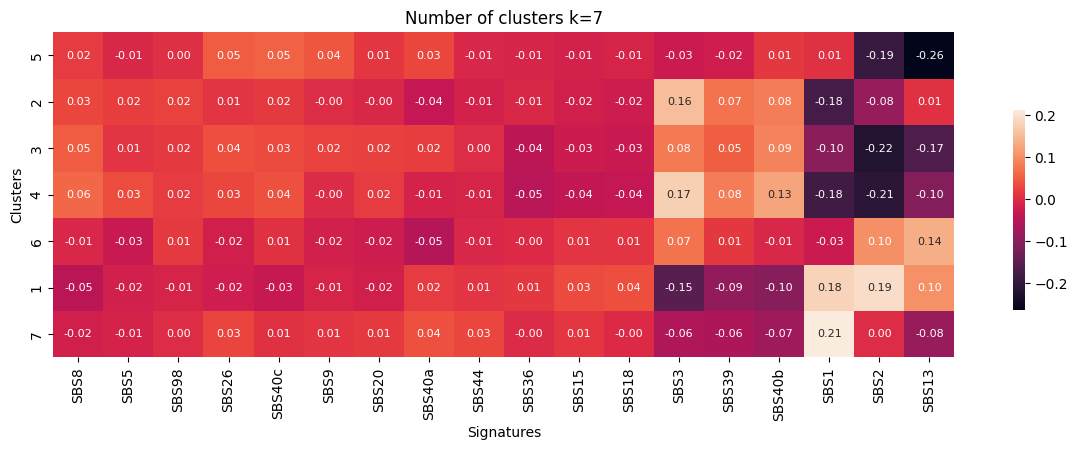

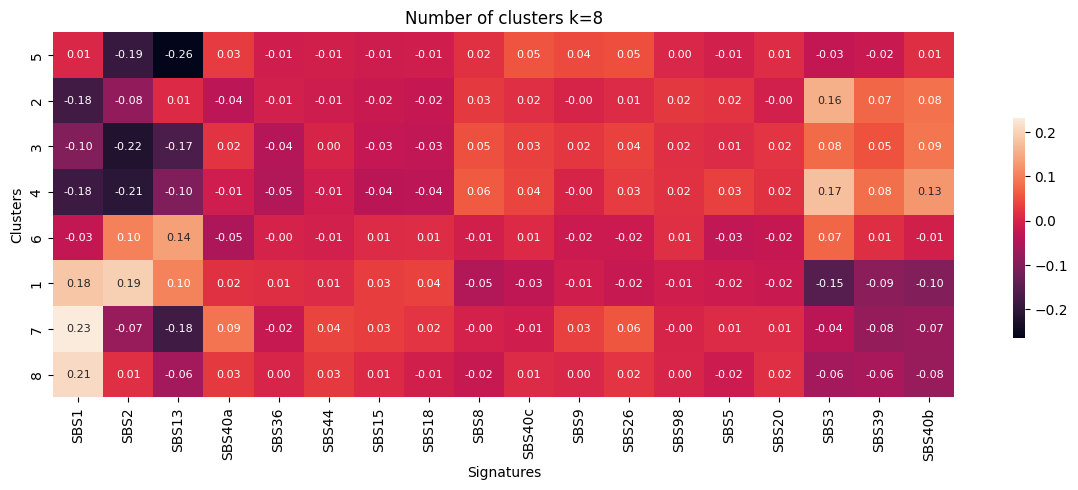

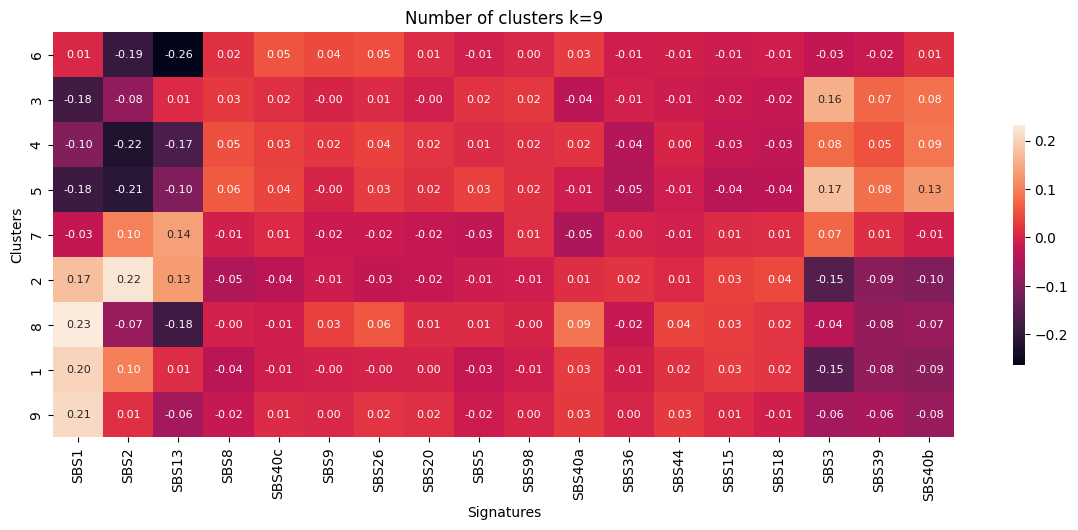

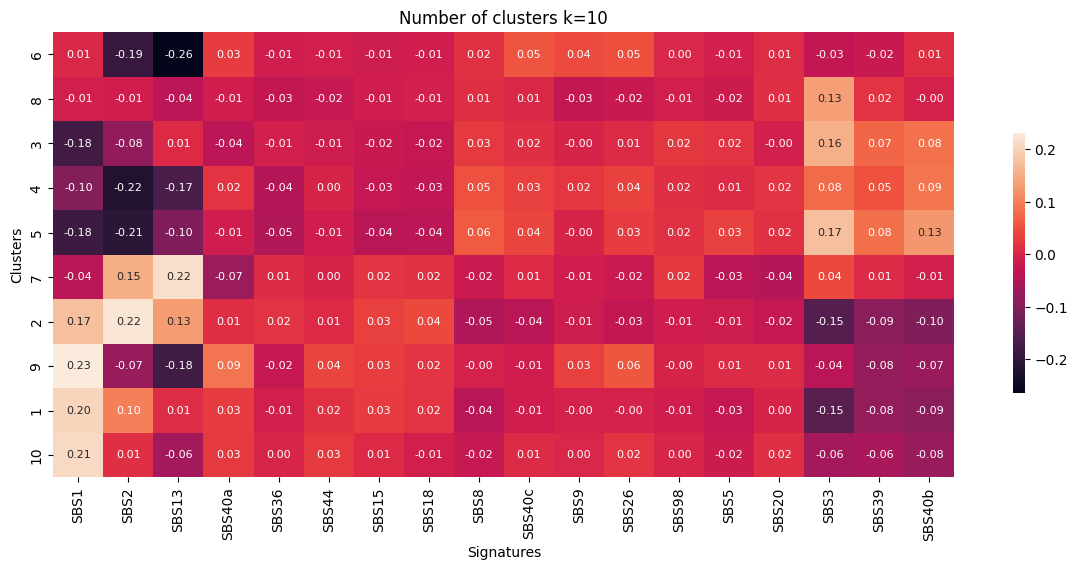

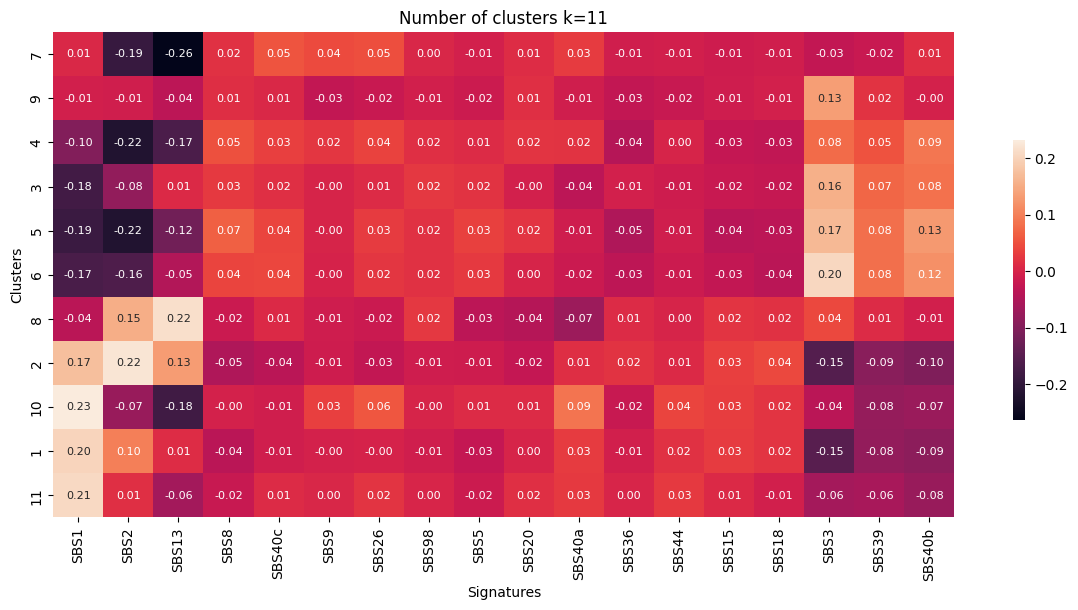

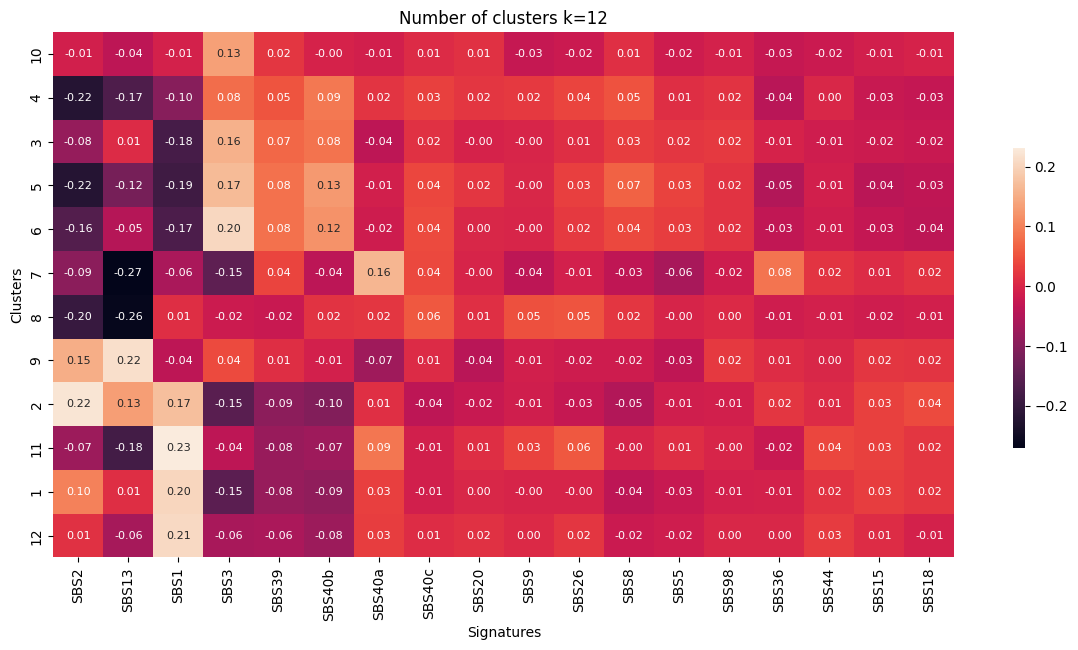

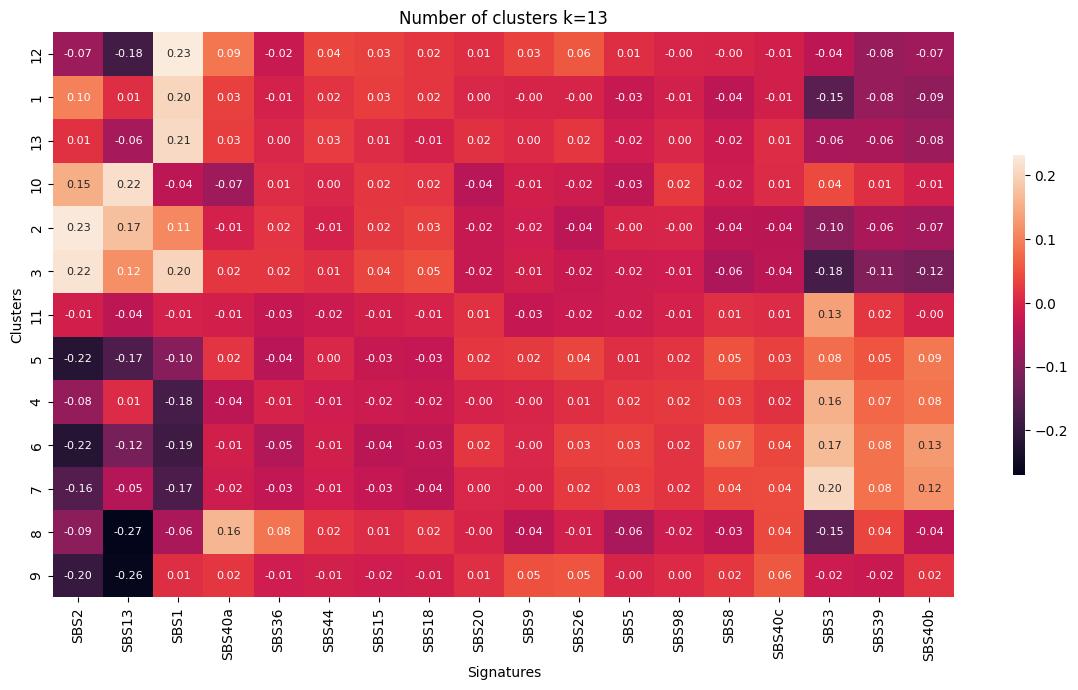

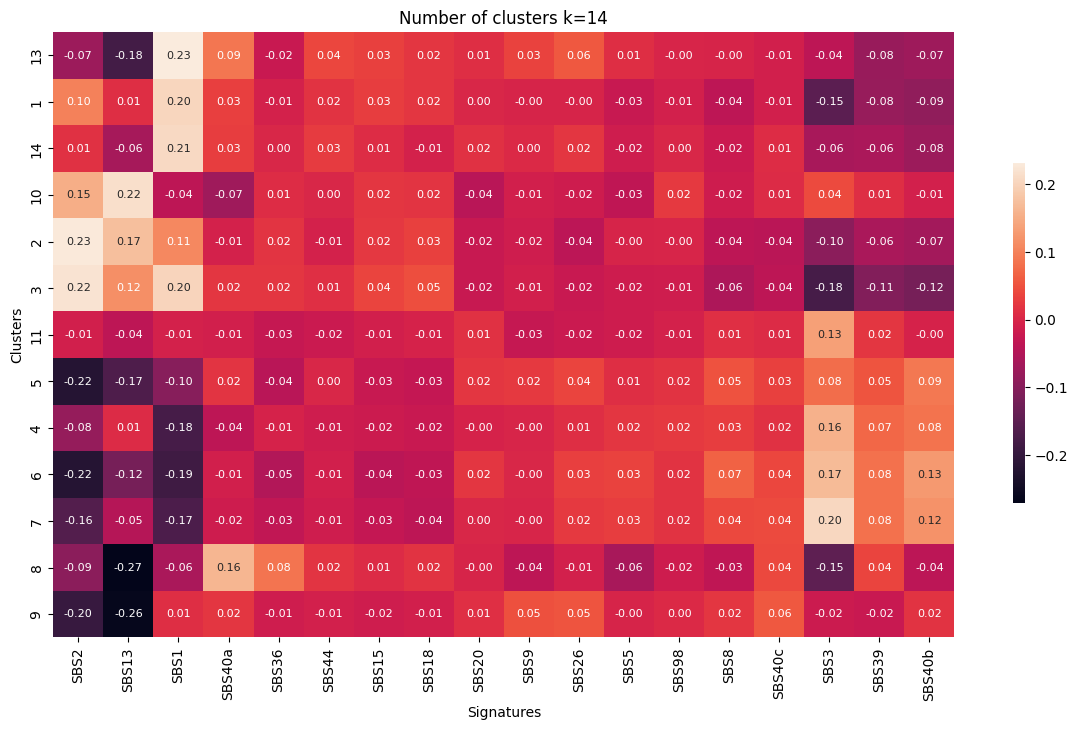

In [151]:
# Keep only genes associated with GO terms
corr_df = corr_count.loc[list(genes_of_interest)]

# Plot average correlation for each cluster (for every k)
for label in all_cluster_df.columns:
    k = int(label.split('=')[1])
    avg_corr_df = avg_cluster_corr(corr_df, label)
    
    # Plot
    g = sns.clustermap(avg_corr_df, annot=True, fmt='.2f',
                       annot_kws={'size': 8}, figsize=(12,0.5*k+1.5),
                       row_cluster=True, col_cluster=True,
                       cbar_pos=(1,0.25,0.01,0.4))
    
    g.ax_heatmap.set_title(f'Number of clusters {label}')
    g.ax_heatmap.set_xlabel('Signatures')
    g.ax_heatmap.set_ylabel('Clusters')
    g.ax_heatmap.yaxis.set_label_position('left')
    g.ax_heatmap.tick_params('y', left=True, labelleft=True, right=False, labelright=False)
    g.ax_row_dendrogram.set_visible(False)
    g.ax_col_dendrogram.set_visible(False)
    
    plt.savefig(f'results/avg_cluster_corr_plots/avg_cluster_corr_{label}.png', bbox_inches='tight')
    plt.show()
    